In [1]:
#!pip install pytictoc
#!pip install pytictoc --upgrade

#!pip install gmpy2
#!pip install mpmath

As of now the Qnk values seem to be saving indexing oddly, (an extra zero at the front) attempt to address this before further steps taking in tuning

In [2]:
from __future__ import division
import numpy as np
import sys
import matplotlib.pylab as plt
import pandas as pd
import open3d as o3d
import scipy
import math
from mpmath import mp
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d
from pytictoc import TicToc

tt = TicToc() #create instance of class
tt.tic()

#np.seterr(all='raise')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
#load in vessel data frame

try:
    vessel_df = pd.read_pickle ('C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project\\larm.pkl')
except:
    vessel_df = pd.read_pickle ('C:\\Users\\Cassidy.Northway\\RemoteGit\\larm.pkl')
#display(vessel_df)

vessel_df = vessel_df.loc[0:2]
#vessel_df.at[0,'End Condition'] = [1, 2]
vessel_df.at[1,'End Condition'] = 'LW'
vessel_df.at[2,'End Condition'] = 'LW'
#vessel_df.at[4,'End Condition'] = 'LW'
#vessel_df.at[0,'Radius Values'] = [0.37, 0.37]
vessel_df.at[0,'Radius Values'] = [0.37, 0.37]
vessel_df.at[1,'Radius Values'] = [0.177, 0.17]
vessel_df.at[2,'Radius Values'] = [0.177, 0.17]
#vessel_df.at[4,'Radius Values'] = [0.06, 0.056]
vessel_df.at[0, 'lam'] =56.22
vessel_df.at[1, 'lam'] =100
vessel_df.at[2, 'lam'] =99.4
#vessel_df.at[3, 'lam'] =100
#vessel_df.at[4, 'lam'] =100

display(vessel_df)

Name    lam  Radius Values End Condition  \
0  left_arm_artery_0  56.22   [0.37, 0.37]        [1, 2]   
1  left_arm_artery_1    100  [0.177, 0.17]            LW   
2  arteries_larm10_0   99.4  [0.177, 0.17]            LW   

                         k Array  
0  [20000000.0, -22.5, 865000.0]  
1  [20000000.0, -22.5, 865000.0]  
2  [20000000.0, -22.5, 865000.0]

In [4]:
# %load artery.py

from __future__ import division

import numpy as np
import sys
import matplotlib.pylab as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.interpolate import interp1d


class Artery(object):
    """
    Class representing an artery.
    
    :param pos: Artery ID
    :param Ru: Upstream radius
    :param Rd: Downstream radius
    :param lam: Length-to-radius (upstream) ratio 
    :param k: Iterable containing elasticity parameters k1, k2, k3
    :param Re: Reynold's number
    :param p0: Zero transmural pressure
    :param alpha: radii ratio for structured tree
    :param beta: radii ratio for structured tree
    :param r_min: minimum radius 
    :param Z_term: terminal impedance
    """
        
        
    def __init__(self, pos, Ru, Rd, lam, k, Re, p0, alpha, beta, r_min, Z_term):
        """
        Artery constructor.
        """
        self._pos = pos
        self._Ru = Ru
        self._Rd = Rd
        self._L = Ru*lam
        self._k = k
        self._Re = Re
        self._p0 = p0
        self._alpha = alpha
        self._beta = beta
        self._r_min = r_min
        self._Z_term = Z_term
        
    def impedance_weights(self, r_root,dt, T,tc):
        acc = 1e-10 #numerical accuracy of impedance fcn
        N = math.ceil(1/dt)
        eta = acc**(1/(2*N))
        empty_table = {}
        m = np.linspace(0,2*np.pi,(2*N)+1) #actual [0:2N-1] the size of 2N
        zeta = eta * np.exp(1j*m)
        Xi = 0.5*(zeta**2) - (2*zeta) + (3/2)
        [Z_impedance, table] = Artery.impedance(self, Xi/dt, r_root, 0, 0, empty_table)
        print('Progress: Impedance calculated')
        z_n = np.zeros(int(T/dt)*tc, dtype = np.complex_)
        weighting = np.concatenate (([1], 2*np.ones(2*N-1),[1]))/ (4 * N) 
        for n in range(0,N+1): # actual range [0,N]
            z_n[n] = ((1/(eta**n))*np.sum(weighting*Z_impedance * np.exp(-1j*n*m)))
        print('Progress: z[n] values calculated')
        z_n = np.real(z_n)
        
        #plt.plot(z_n,'.')
        #print(z_n[0:10])
        #plt.show()

        return z_n
    
    def impedance(self, s, r_root, N_alpha, N_beta, table):
        ZL = np.zeros(np.size(s), dtype = np.complex_)
        r_0 = r_root * (alpha ** N_alpha) *(beta ** N_beta)
        if r_0 < r_min:
        
            ZL[:] = 0
        else:
            try:
                ZD1 = table[N_alpha + 1 , N_beta]
            except:
                [ZD1, table] = Artery.impedance( self, s,r_root,N_alpha+1,N_beta,table)
            try:
                ZD2 = table[N_alpha, N_beta +1,:]
            except:
                [ZD2, table] = Artery.impedance(self, s, r_root, N_alpha, N_beta + 1, table)
            
            
       
            ZL = (ZD1 * ZD2) / (ZD1 + ZD2)#ZL needs to be an array of values over the s_range size
        
        Z0 = Artery.singleVesselImpedance(ZL,s,r_0)
        table[N_alpha,N_beta] = Z0
        return [Z0, table]
                     
    def singleVesselImpedance(ZL, s_range, r_0):
        gamma = 2 #velocity profile
        mu = 0.048 #blood viscosity
        lambd = 50 #length/radius ratio
        rho = 1.055 #blood density
        L = r_0 *lambd
        A0 = np.pi * (r_0 ** 2)
        Ehr = (2e7 *np.exp( -22.5*r_0) + 8.65e5) #Youngs Modulus * vessel thickness/radius
        C = (3/2) *(A0)/(Ehr)#complaince
        delta = (2 * mu*(gamma +2))/ (rho *r_0**2)
        i = 0
        Z0 = np.zeros(np.size(s_range), dtype = np.complex_)
        for s in s_range:
            if s == 0:
                Z0[i] = ZL[i] + (2*(gamma +2)*mu* lambd) / (np.pi * r_0**3)
                print('s=0')
            else:
                d_s = (A0/(C*rho*s*(s+delta)))**(0.5)
                num = ZL[i] +np.tanh(L/d_s)/(s*d_s*C)
                denom = s*d_s*C*ZL[i]*np.tanh(L/d_s) + 1
                Z0[i] = num/denom
            i = i + 1
        return Z0
                           
    def initial_conditions(self, u0, dt, dataframe, T, tc):
        """
        Initialises solution arrays with initial conditions.
        Checks if artery.mesh(dx) has been called first.
        
        :param u0: Initial conditions for solution
        :param ntr: Number of solution time steps to be stored
        :raises: AttributeError
        """
        if not hasattr(self, '_nx'):
            raise AttributeError('Artery not meshed. Execute mesh(self, dx) \
before setting initial conditions.')
        self.U0[0,:] = self.A0.copy()
        self.U0[1,:].fill(u0)
        self.Uold = self.U0.copy()
        
        if  dataframe.at[self.pos,'End Condition'] == 'LW':
            zn = Artery.impedance_weights(self, self.Rd, dt, T, tc)
            self._zn = zn
            self._Qnk = np.zeros(int(T/dt)*tc)
        else:
            self._zn = 0
            self._Qnk = 0
           
    def mesh(self, dx, ntr):
        """
        Meshes an artery using spatial step size dx.
        
        :param dx: Spatial step size
        """
        self._dx = dx
        self._nx = int(self.L/dx)+1
        if self.nx-1 != self.L/dx:
            self.L = dx * (self.nx-1)
        X = np.linspace(0.0, self.L, self.nx)
        R = self.Ru * np.power((self.Rd/self.Ru), X/self.L)
        self._A0 = np.power(R, 2)*np.pi
        self._f = 4/3 * (self.k[0] * np.exp(self.k[1]*R) + self.k[2])
        self._df = 4/3 * self.k[0] * self.k[1] * np.exp(self.k[1]*R)
        self._xgrad = (self.Ru * np.log(self.Rd/self.Ru) * np.power((self.Rd/self.Ru), X/self.L))/self.L
        self.U = np.zeros((2, ntr, self.nx))
        self.P = np.zeros((ntr, self.nx))
        self.U0 = np.zeros((2, self.nx))
        self.Uold = np.zeros((2, self.nx))
        
    def boundary_layer_thickness(self, nu, T):
        """
        Calculates the boundary layer thickness of the artery according to
        
        delta = sqrt(nu*T/2*pi).
        
        :param nu: Viscosity of blood
        :param T: Length of one periodic cycle.
        """
        self._delta = np.sqrt(nu*T/(2*np.pi))
        
        
    def p(self, a, **kwargs):
        """
        Calculates pressure according to the state equation.
        
        :param a: Area
        :param \**kwargs: See below
        :returns: Pressure 

        :Keyword Arguments:
            * *j* (``int``) -- Index variable
        """
        if 'j' in kwargs:
            j = kwargs['j']
            p = self.f[j] * (1 - np.sqrt(self.A0[j]/a)) + self.p0
        else:
            p = self.f * (1 - np.sqrt(self.A0/a)) + self.p0
        return p
        

    def wave_speed(self, a):
        """
        Calculates the wave speed (required to check CFL condition).
        
        :param a: Area
        :returns: Wave speed
        """
        return -np.sqrt(0.5 * self.f * np.sqrt(self.A0/a))
        
        
    def F(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.empty_like(U)
        out[0] = q
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            f = self.f[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            f = self.f[j:k]
        else:
            raise IndexError("Required to supply at least one index in function F.")
            
        
        out[1] = np.power(q, 2)/a + f * np.sqrt(a0*a)
       
      
        return out
        
        
    def S(self, U, **kwargs):
        """
        Calculates the flux vector.
        
        :param U: Previous solution
        :param \**kwargs: See below
        :returns: Flux for current solution
        :raises: IndexError
        
        :Keyword Arguments:
            * *j* (``int``) -- Index variable (start)
            * *k* (``int``) -- Index variable (end)
        """
        a, q = U
        out = np.zeros(U.shape)
        if 'j' in kwargs:
            j = kwargs['j']
            a0 = self.A0[j]
            xgrad = self.xgrad[j]
            f = self.f[j]
            df = self.df[j]
        elif 'k' in kwargs:
            j = kwargs['j']
            k = kwargs['k']
            a0 = self.A0[j:k]
            xgrad = self.xgrad[j:k]
            f = self.f[j:k]
            df = self.df[j:k]
        else:
            raise IndexError("Required to supply at least one index in function S.")
        R = np.sqrt(a0/np.pi)
        
        out[1] = -(2*np.pi*R/(self.Re*self.delta)) * (q/a) +\
                (2*np.sqrt(a) * (np.sqrt(np.pi)*f +\
                np.sqrt(a0)*df) - a*df) * xgrad

       
        return out
        
        
    def dBdx(self, l, xi):
        """
        Calculates dB/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            df_l = extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
            df_l = extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
            df_l = self.df[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
            df_l = self.df[0]
            xgrad_l = self.xgrad[0]
        return (2*np.sqrt(xi) * (np.sqrt(np.pi)*f_l + np.sqrt(A0_l)*df_l) -\
                    xi*df_l) * xgrad_l
        
        
    def dBdxi(self, l, xi):
        """
        Calculates dB/dx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dB/dx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])  
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]]) 
        elif l == self.L:
            f_l = self.f[-1]
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi)
        
        
    def dBdxdxi(self, l, xi):
        """
        Calculates d^2B/dxdx_i (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to d^2B/dxdx_i
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            df_l = extrapolate(l, [x_0, x_1], [self.df[-2], self.df[-1]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[-2], self.xgrad[-1]])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            df_l = extrapolate(l, [x_0, x_1], [self.df[1], self.df[0]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])  
            xgrad_l = extrapolate(l, [x_0, x_1],
                                        [self.xgrad[1], self.xgrad[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            df_l = self.df[-1]
            A0_l = self.A0[-1]
            xgrad_l = self.xgrad[-1]
        else:
            f_l = self.f[0]   
            df_l = self.df[0]
            A0_l = self.A0[0]
            xgrad_l = self.xgrad[0]
     
        return (1/(2*np.sqrt(xi)) * (f_l*np.sqrt(np.pi) +\
                                    df_l*np.sqrt(A0_l)) - df_l) * xgrad_l
        
                                    
                                    
    def dFdxi2(self, l, xi1, xi2):
        """
        Calculates dF/dx_2 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_2
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return 2*np.pi*R0_l/(self.delta*self.Re) * xi1/(xi2*xi2)
        
        
    def dFdxi1(self, l, xi2):
        """
        Calculates dF/dx_1 (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dF/dx_1
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[-2]/np.pi), np.sqrt(self.A0[-1]/np.pi)])
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            R0_l = extrapolate(l, [x_0, x_1], 
                    [np.sqrt(self.A0[1]/np.pi), np.sqrt(self.A0[0]/np.pi)])
        elif l == self.L:
            R0_l = np.sqrt(self.A0[-1]/np.pi)
        else:
            R0_l = np.sqrt(self.A0[0]/np.pi)
        return -2*np.pi*R0_l/(self.delta*self.Re) * 1/xi2
        
        
    def dpdx(self, l, xi):
        """
        Calculates dp/dx (see [1]).
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param l: Position, either M+1/2 or -1/2.
        :param xi: Area.
        :returns: Solution to dp/dx
        """
        if l > self.L:
            x_0 = self.L-self.dx
            x_1 = self.L
            f_l = extrapolate(l, [x_0, x_1], [self.f[-2], self.f[-1]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[-2], self.A0[-1]])  
        elif l < 0.0:
            x_0 = self.dx
            x_1 = 0.0
            f_l = extrapolate(l, [x_0, x_1], [self.f[1], self.f[0]])   
            A0_l = extrapolate(l, [x_0, x_1], [self.A0[1], self.A0[0]])
        elif l == self.L:
            f_l = self.f[-1]   
            A0_l = self.A0[-1]
        else:
            f_l = self.f[0]   
            A0_l = self.A0[0]
        return f_l/2 * np.sqrt(A0_l/xi**3)
        
        
    def solve(self, lw, U_in, U_out, save, i):
        """
        Solver calling the LaxWendroff solver and storing the new solution in U0.lw
        Stores new solution in output array U if save is True.
        
        :param lw: LaxWendroff object
        :param U_in: Inlet boundary condition
        :param U_out: Outlet boundary condition
        :param save: True if current time step is to be saved
        :param i: Current time step
        """
        # solve for current timestep
        U1 = lw.solve(self.U0, U_in, U_out, self.F, self.S)
        if save:
            self.P[i,:] = self.p(self.U0[0,:])
            np.copyto(self.U[:,i,:], self.U0)
        np.copyto(self.Uold,self.U0)
        np.copyto(self.U0, U1)
        

    def dump_results(self, suffix, data_dir):
        """
        Outputs solutions U, P to csv files
        
        :param suffix: Simulation identifier
        :param data_dir: Directory data files are stored in
        """
        np.savetxt("%s/%s/u%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[1,:,:], delimiter=',')
        np.savetxt("%s/%s/a%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.U[0,:,:], delimiter=',')  
        np.savetxt("%s/%s/p%d_%s.csv" % (data_dir, suffix, self.pos, suffix),
                   self.P, delimiter=',') 
                   
                   
    @property
    def L(self):
        """
        Artery length
        """
        return self._L

    @L.setter
    def L(self, value):
        self._L = value
        
    @property
    def nx(self):
        """
        Number of spatial steps
        """
        return self._nx
        
    @property
    def Ru(self):
        """
        Upstream radius
        """
        return self._Ru
        
    @property
    def Rd(self):
        """
        Downstream radius
        """
        return self._Rd
        
    @property
    def k(self):
        """
        Elasticity parameters for relation Eh/r = k1 * exp(k2*r) + k3
        """
        return self._k
        
    @property
    def A0(self):
        """
        Area at rest
        """
        return self._A0
        
    @property
    def dx(self):
        """
        Spatial step size
        """
        return self._dx
    
    @property
    def pos(self):
        """
        Position in ArteryNetwork
        """
        return self._pos
        
    @property
    def f(self):
        """
        f = 4/3 Eh/r
        """
        return self._f
        
    @property
    def xgrad(self):
        """
        dr/dx
        """
        return self._xgrad
        
    @property
    def df(self):
        """
        df/dr
        """        
        return self._df

    @property
    def Re(self):
        """
        Reynold's number
        """
        return self._Re
        
    @property
    def delta(self):
        """
        Boundary layer thickness
        """
        return self._delta

    @property
    def p0(self):
        """
        Zero transmural pressure
        """
        return self._p0
    
    @property
    def alpha(self):
        """
        Radii ratio for structured tree calculations
        """
        return self._alpha
    
    @property
    def beta(self):
        """
        Radii ratio for structured tree calculations
        """
        return self._beta                     
                     
    @property
    def r_min(self):
        """
        Minimum radius at which structured trees terminate
        """
        return self._r_min
                     
                     
    @property
    def Z_term(self):
        """
        Terminal impedance of structured trees
        """
        return self._Z_term 
                     
    @property
    def zn(self):
        """
        Impedance weights 
        """
        return self._zn
    
    @property
    def Qnk(self):
        """
        Stored flow values for structured tree values
        """
        return self._Qnk
    #def Lrr

In [5]:
# %load artery_network.py

from __future__ import division
import numpy as np

from scipy import linalg



from os import makedirs
from os.path import exists

import sys



class ArteryNetwork(object):
    """
    Class representing a network of arteries.
    
    :param Ru: Iterable containing upstream radii.
    :param Rd: Iterable containing downstream radii.
    :param lam: Iterable containing length-to-radius ratios.
    :param k: Iterable containing elasticity parameters.
    :param rho: Density of blood.
    :param nu: Viscosity of blood.
    :param p0: Zero transmural pressure.
    :param depth: Depth of the arterial tree, e. g. 1 for one artery, 2 for three arteries. ##I WANT TO EDIT THIS CONCEPT OUT
    :param ntr: Number of time steps in output.
    :param Re: Reynolds number.
    :param dataframe: Dataframe containing the artery information
    :param alpha: Radii ratio for structured tree
    :param beta: Radii ratio for structured tree
    :param r_min: Minimum radii
    :param Z_term: Terminal impedance
    """
    
    
    def __init__(self, rho, nu, p0, ntr, Re, k, dataframe, Z_term, alpha, beta, r_min,):
        """
        ArteryNetwork constructor.
        """
        #MODIFIED TO: NOT USE DEPTH TO create all the arteries but create arteries for all arteries in dataframe    
        self._t = 0.0
        self._ntr = ntr
        self._progress = 0
        self._rho = rho
        self._nu = nu
        self._p0 = p0
        self._k = k
        self._dataframe = dataframe 
        self._arteries = [0] * len(dataframe)
        self.setup_arteries(Re, p0, k,alpha, beta, r_min, Z_term)     
        
    def setup_arteries(self, Re, p0, k, alpha, beta, r_min, Z_term):
        """
        Creates Artery objects.
        
        :param Ru: Iterable containing upstream radii.
        :param Rd: Iterable containing downstream radii.
        :param lam: Iterable containing length-to-radius ratios.
        :param k: Iterable containing elasticity parameters.
        :param Re: Reynolds number.
        :param Z_term: 
        """
        
        #Creates all artery objects 
        for i in range(0,len(dataframe)):
            Ru = dataframe.at[i,'Radius Values'][0] 
            Rd = dataframe.at[i,'Radius Values'][1]
            lam = dataframe.at[i,'lam']
            #k = dataframe.at[i,'k Array']
            self.arteries[i] = Artery(i, Ru, Rd, lam, k, Re, p0, alpha, beta, r_min, Z_term)

                   
    def initial_conditions(self, u0, dataframe):
        """
        Invokes initial_conditions(u0) on each artery in the network.
        
        :param u0: Initial condition for U_1.
        """
        for artery in self.arteries:
            artery.initial_conditions(u0, self.dt, dataframe, self.T, self.tc)
            
            
            
    def mesh(self, dx):
        """
        Invokes mesh(nx) on each artery in the network
        
        :param dx: Spatial step size
        """
        for artery in self.arteries:
            artery.mesh(dx, self.ntr)
            
            
    def set_time(self, dt, T, tc=1):
        """
        Sets timing parameters for the artery network and invokes
        boundary_layer_thickness(T) in each artery.
        
        :param dt: Time step size.
        :param T: Length of one periodic cycle.
        :param tc: Number of cycles.
        """
        self._dt = dt
        self._tf = T*tc
        self._dtr = self.tf/self.ntr
        self._T = T
        self._tc = tc
        for artery in self.arteries:
            artery.boundary_layer_thickness(self.nu, T)
            
            
    def timestep(self):
        """
        Increases time by dt.
        """
        self._t += self.dt
            
    
    @staticmethod        
    def inlet_bc(artery, q_in, in_t, dt):
        """
        Calculates inlet boundary condition.
        
        :param artery: Inlet artery.
        :param q_in: Function containing inlet condition U_1(t).
        :param in_t: Current time.
        :param dt: Time step size.
        :returns: Array containing solution U at the inlet. 
        """
        q_0_np = q_in(in_t-dt/2) # q_0_n+1/2
        q_0_n1 = q_in(in_t) # q_0_n+1
        U_0_n = artery.U0[:,0] # U_0_n
        U_1_n = artery.U0[:,1]
        U_12_np = (U_1_n+U_0_n)/2 -\
                    dt*(artery.F(U_1_n, j=1)-artery.F(U_0_n, j=0))/(2*artery.dx) +\
                    dt*(artery.S(U_1_n, j=1)+artery.S(U_0_n, j=0))/4 # U_1/2_n+1/2
        a_0_n1 = U_0_n[0] - 2*dt*(U_12_np[1] - q_0_np)/artery.dx
        return np.array([a_0_n1, q_0_n1])
     
    
    @staticmethod
    def outlet_wk3(artery, dt, R1, R2, Ct):
        """
        Function calculating the three-element Windkessel outlet boundary
        condition.
        
        :param artery: Artery object of outlet artery
        :param dt: time step size
        :param R1: first resistance element
        :param R2: second resistance element
        :param Ct: compliance element
        :returns: Numpy array containing the outlet area and flux
        """
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1] # m = M
        U0_2 = artery.U0[:,-2] # m = M-1
        U0_3 = artery.U0[:,-3] # m = M-2
        a_n, q_n = U0_1
        p_new = p_n = artery.p(a_n, j=-1) # initial guess for p_out
        U_np_mp = (U0_1 + U0_2)/2 +\
                gamma * (-(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/artery.dx +\
                        (artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2)
        U_np_mm = (U0_2 + U0_3)/2 +\
                gamma * (-(artery.F(U0_2, j=-2) - artery.F(U0_3, j=-3))/artery.dx +\
                        (artery.S(U0_2, j=-2) + artery.S(U0_3, j=-3))/2)
        U_mm = U0_2 - theta*(artery.F(U_np_mp, j=-2) - artery.F(U_np_mm, j=-2)) +\
                gamma*(artery.S(U_np_mp, j=-2) + artery.S(U_np_mm, j=-2))
        k = 0
        X = dt/(R1*R2*Ct)
        while k < 1000:
            p_old = p_new
            q_out = X*p_n - X*(R1+R2)*q_n + (p_old-p_n)/R1 + q_n
            a_out = a_n - theta * (q_out - U_mm[1])
            p_new = artery.p(a_out, j=-1)
            if abs(p_old - p_new) < 1e-7:
                break
            k += 1
        return np.array([a_out, q_out])
    
    
    @staticmethod
    def outlet_p(artery, dt, P):
        """
        Function calculating cross-sectional area and flow rate for a fixed
        pressure outlet boundary condition.
        
        :param artery: Artery object of outlet artery
        :param dt: time step size
        :param P: outlet pressure
        """
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1]
        U0_2 = artery.U0[:,-2]
        a_n, q_n = U0_1
        p_out = P # initial guess for p_out
        a_out = (artery.A0[-1]*artery.f[-1]**2) / (artery.f[-1] - p_out)**2
        U_np_mm = (U0_1 + U0_2)/2 -\
                theta*(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/2 +\
                gamma*(artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2
        a_np_mp = 2*a_out - U_np_mm[0]
        q_np_mp = (a_n - a_out)/theta + U_np_mm[1]
        U_np_mp = np.array([a_np_mp, q_np_mp])
        U_out = U0_1 - theta*(artery.F(U_np_mp, j=-1) - artery.F(U_np_mm, j=-1)) +\
                gamma*(artery.S(U_np_mp, j=-1) + artery.S(U_np_mm, j=-1))
        return U_out
    

    @staticmethod
    def outlet_st(artery, dt, t):
        """
        :param t: Current time step, within the period, 0<=t<=T
        """
        k_array = np.arange(0,t+dt,dt) #actual range [0,t]
        n_value = np.size(k_array)
        zk_array = artery.zn[0:n_value+1]
        Qnk_array = np.flip(artery.Qnk[0:n_value+1])
        print('n_value:', n_value)
        print('Qnk_flipped:', Qnk_array)
        #Need to have stored Q values for every time step up to this point
        #for k = 0 to n (n=current number of time steps)
        p_out = np.sum(zk_array*Qnk_array)  #pressure at nth time step with constant time steps dt
                    
        #Here I take the outlet_p code from above
        theta = dt/artery.dx
        gamma = dt/2
        U0_1 = artery.U0[:,-1]
        U0_2 = artery.U0[:,-2]
        a_n, q_n = U0_1
        a_out = (artery.A0[-1]*artery.f[-1]**2) / (artery.f[-1] - p_out)**2
        U_np_mm = (U0_1 + U0_2)/2 -\
                theta*(artery.F(U0_1, j=-1) - artery.F(U0_2, j=-2))/2 +\
                gamma*(artery.S(U0_1, j=-1) + artery.S(U0_2, j=-2))/2
        a_np_mp = 2*a_out - U_np_mm[0]
        q_np_mp = (a_n - a_out)/theta + U_np_mm[1]
        U_np_mp = np.array([a_np_mp, q_np_mp])
        U_out = U0_1 - theta*(artery.F(U_np_mp, j=-1) - artery.F(U_np_mm, j=-1)) +\
                gamma*(artery.S(U_np_mp, j=-1) + artery.S(U_np_mm, j=-1))
        return U_out
         #Do we want to reset k at t>T or do we want to have total t regardless of number of T
    @staticmethod
    def jacobian(x, parent, d1, d2, theta, gamma):
        """
        Calculates the Jacobian for using Newton's method to solve bifurcation inlet and outlet boundary conditions [1].
        
        [1] [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        
        :param x: Solution of the system of equations.
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param theta: dt/dx
        :param gamma: dt/2
        :returns: The Jacobian for Newton's method.
        """
        M12 = parent.L + parent.dx/2
        D1_12 = -d1.dx/2
        D2_12 = -d2.dx/2
        zeta7 = -parent.dpdx(parent.L, x[10])
        zeta10 = -parent.dpdx(parent.L, x[9])
        Dfr = np.zeros((18, 18)) # Jacobian
        Dfr[0,0] = Dfr[1,3] = Dfr[2,6] = Dfr[3,9] = Dfr[4,12] = Dfr[5,15] = -1
        Dfr[6,1] = Dfr[7,4] = Dfr[8,7] = Dfr[9,10] = Dfr[10,13] = Dfr[11,16] = -1
        Dfr[12,1] = Dfr[13,0] = -1
        Dfr[6,2] = Dfr[7,5] = Dfr[8,8] = Dfr[9,11] = Dfr[10,14] = Dfr[11,17] = 0.5
        Dfr[12,4] = Dfr[12,7] = Dfr[13,3] = Dfr[13,6] = 1.0
        Dfr[3,2] = -theta
        Dfr[4,5] = Dfr[5,8] = theta
        Dfr[0,2] = -2*theta*x[2]/x[11] + gamma*parent.dFdxi1(M12, x[11])
        Dfr[0,11] = theta * (x[2]**2/x[11]**2 - parent.dBdxi(M12,x[11])) +\
                    gamma * (parent.dFdxi2(M12, x[2], x[11]) +\
                            parent.dBdxdxi(M12, x[11]))
        Dfr[1,5] = 2*theta*x[5]/x[14] + gamma*d1.dFdxi1(D1_12, x[14])
        Dfr[1,14] = theta * (-x[5]**2/x[14]**2 + d1.dBdxi(D1_12,x[14])) +\
                    gamma * (d1.dFdxi2(D1_12, x[5], x[14]) +\
                            d1.dBdxdxi(D1_12, x[14]))
       
        Dfr[2,8] = 2*theta*x[8]/x[17] + gamma*d2.dFdxi1(D2_12, x[17])
        
        Dfr[2,17] = theta * ((-x[8]**2/x[17]**2 + 0) +\
                    gamma * (0) +\
                            d2.dBdxdxi(D2_12, x[17]))
       
        Dfr[14,10] = zeta7
        Dfr[14,13] = d1.dpdx(0.0, x[13])
        Dfr[15,10] = zeta7
        Dfr[15,16] = d2.dpdx(0.0, x[16])
        Dfr[16,9] = zeta10
        Dfr[16,12] = d1.dpdx(0.0, x[12])
        Dfr[17,9] = zeta10
        Dfr[17,15] = d2.dpdx(0.0, x[15])

        return Dfr
        

    @staticmethod
    def residuals(x, parent, d1, d2, theta, gamma, U_p_np, U_d1_np, U_d2_np):
        """
        Calculates the residual equations for using Newton's method to solve bifurcation inlet and outlet boundary conditions [1].
        
        [1] M. S. Olufsen. Modeling of the Arterial System with Reference to an Anesthesia Simulator. PhD thesis, University of Roskilde, Denmark, 1998.
        [2] R. J. LeVeque. Numerical Methods for Conservation Laws. Birkhauser Verlag, Basel, Switzerland, 2nd edition, 1992.
        
        :param x: Solution of the system of equations.
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param theta: dt/dx
        :param gamma: dt/2
        :param U_p_np: U_(M-1/2)^(n+1/2) [2]
        :param U_p_np: U_(M-1/2)^(n+1/2) [2]
        :returns: The residual equations for Newton's method.
        """
        f_p_mp = extrapolate(parent.L+parent.dx/2,
                [parent.L-parent.dx, parent.L], [parent.f[-2], parent.f[-1]])
        f_d1_mp = extrapolate(-d1.dx/2, [d1.dx, 0.0],
                                    [d1.f[1], d1.f[0]])
        f_d2_mp = extrapolate(-d2.dx/2, [d2.dx, 0.0],
                                    [d2.f[1], d2.f[0]])
        A0_p_mp = extrapolate(parent.L+parent.dx/2,
                [parent.L-parent.dx, parent.L], [parent.A0[-2], parent.A0[-1]])
        A0_d1_mp = extrapolate(-d1.dx/2, [d1.dx, 0.0],
                                     [d1.A0[1], d1.A0[0]])
        A0_d2_mp = extrapolate(-d2.dx/2, [d2.dx, 0.0],
                                     [d2.A0[1], d2.A0[0]])
        R0_p_mp = np.sqrt(A0_p_mp/np.pi)
        R0_d1_mp = np.sqrt(A0_d1_mp/np.pi)
        R0_d2_mp = np.sqrt(A0_d2_mp/np.pi)
        B_p_mp = f_p_mp * np.sqrt(x[11]*A0_p_mp)
        B_d1_mp = f_d1_mp * np.sqrt(x[14]*A0_d1_mp)
        B_d2_mp = f_d2_mp * np.sqrt(x[17]*A0_d2_mp)
        k1 = parent.U0[1,-1] + theta * (parent.F(U_p_np, j=-1)[1]) +\
                gamma * (parent.S(U_p_np, j=-1)[1])
        k2 = d1.U0[1,0] - theta * (d1.F(U_d1_np, j=0)[1]) +\
                gamma * (d1.S(U_d1_np, j=0)[1])
        k3 = d2.U0[1,0] - theta * (d2.F(U_d2_np, j=0)[1]) +\
                gamma * (d2.S(U_d2_np, j=0)[1])
        k4 = parent.U0[0,-1] + theta*parent.F(U_p_np, j=-1)[0]
        k5 = d1.U0[0,0] - theta*d1.F(U_d1_np, j=0)[0]
        k6 = d2.U0[0,0] - theta*d2.F(U_d2_np, j=0)[0]
        k7 = U_p_np[1]/2
        k8 = U_d1_np[1]/2
        k9 = U_d2_np[1]/2
        k10 = U_p_np[0]/2
        k11 = U_d1_np[0]/2
        k12 = U_d2_np[0]/2
        k15a = -parent.f[-1] + d1.f[0]
        k15b = d1.f[0] * np.sqrt(d1.A0[0])
        k16a = -parent.f[-1] + d2.f[0]
        k16b = d2.f[0] * np.sqrt(d2.A0[0])
        k156 = parent.f[-1] * np.sqrt(parent.A0[-1])
        fr1 = k1 - x[0] - theta*(x[2]**2/x[11] + B_p_mp) +\
                gamma*(-2*np.pi*R0_p_mp*x[2]/(parent.delta*parent.Re*x[11]) +\
                parent.dBdx(parent.L+parent.dx/2, x[11]))
        fr2 = k2 - x[3] + theta*(x[5]**2/x[14] + B_d1_mp) +\
                gamma*(-2*np.pi*R0_d1_mp*x[5]/(d1.delta*d1.Re*x[14]) +\
                d1.dBdx(-d1.dx/2, x[14]))
        fr3 = k3 - x[6] + theta*(x[8]**2/x[17] + B_d2_mp) +\
                gamma*(-2*np.pi*R0_d2_mp*x[8]/(d2.delta*d2.Re*x[17]) +\
                d2.dBdx(-d2.dx/2, x[17]))
        fr4 = -x[9] - theta*x[2] + k4
        fr5 = -x[12] + theta*x[5] + k5
        fr6 = -x[15] + theta*x[8] + k6
        fr7 = -x[1] + x[2]/2 + k7
        fr8 = -x[4] + x[5]/2 + k8
        fr9 = -x[7] + x[8]/2 + k9
        fr10 = -x[10] + x[11]/2 + k10
        fr11 = -x[13] + x[14]/2 + k11
        fr12 = -x[16] + x[17]/2 + k12
        fr13 = -x[1] + x[4] + x[7]
        fr14 = -x[0] + x[3] + x[6]
        fr15 = k156/np.sqrt(x[10]) - k15b/np.sqrt(x[13]) + k15a
        fr16 = k156/np.sqrt(x[10]) - k16b/np.sqrt(x[16]) + k16a
        fr17 = k156/np.sqrt(x[9]) - k15b/np.sqrt(x[12]) + k15a
        fr18 = k156/np.sqrt(x[9]) - k16b/np.sqrt(x[15]) + k16a
        return np.array([fr1, fr2, fr3, fr4, fr5, fr6, fr7, fr8, fr9, fr10,
                         fr11, fr12, fr13, fr14, fr15, fr16, fr17, fr18])
        

    @staticmethod
    def bifurcation(parent, d1, d2, dt):
        """
        Calculates the bifurcation boundary condition using Newton's method.
        
        :param parent: Artery object of the parent vessel.
        :param d1: Artery object of the first daughter vessel.
        :param d2: Artery object of the second daughter vessel.
        :param dt: Time step size.
        :returns: Array containing the solution at the bifurcation boundary.
        """
        flag = 0
        theta = dt/parent.dx
        gamma = dt/2
        U_p_np = (parent.U0[:,-1] + parent.U0[:,-2])/2 -\
                theta*(parent.F(parent.U0[:,-1], j=-1) - parent.F(parent.U0[:,-2], j=-2))/2 +\
                gamma*(parent.S(parent.U0[:,-1], j=-1) + parent.S(parent.U0[:,-2], j=-2))/2
        U_d1_np = (d1.U0[:,1] + d1.U0[:,0])/2 -\
                theta*(d1.F(d1.U0[:,1], j=1) - d1.F(d1.U0[:,0], j=0))/2 +\
                gamma*(d1.S(d1.U0[:,1], j=1) + d1.S(d1.U0[:,0], j=0))/2
        U_d2_np = (d2.U0[:,1] + d2.U0[:,0])/2 -\
                theta*(d2.F(d2.U0[:,1], j=1) - d2.F(d2.U0[:,0], j=0))/2 +\
                gamma*(d2.S(d2.U0[:,1], j=1) + d2.S(d2.U0[:,0], j=0))/2
        x0 = U_p_np[1]
        x1 = (parent.U0[1,-1] + parent.U0[1,-2])/2
        x2 = parent.U0[1,-1]
        x3 = U_d1_np[1]
        x4 = (d1.U0[1,0] + d1.U0[1,1])/2
        x5 = d1.U0[1,0]
        x6 = U_d2_np[1]
        x7 = (d2.U0[1,0] + d2.U0[1,1])/2
        x8 = d2.U0[1,0]
        x9 = U_p_np[0]
        x10 = (parent.U0[0,-1] + parent.U0[0,-2])/2
        x11 = parent.U0[0,-1]
        x12 = U_d1_np[0]
        x13 = (d1.U0[0,0] + d1.U0[0,1])/2
        x14 = d1.U0[0,0]
        x15 = U_d2_np[0]
        x16 = (d2.U0[0,0] + d2.U0[0,1])/2   
        x17 = d2.U0[0,0]
        x = np.array([x0, x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17])
        k = 0
        while k < 1000:
            Dfr = ArteryNetwork.jacobian(x, parent, d1, d2, theta, gamma)
            Dfr_inv = linalg.inv(Dfr)
            fr = ArteryNetwork.residuals(x, parent, d1, d2, theta, gamma, U_p_np, U_d1_np, U_d2_np)
            x1 = x - np.dot(Dfr_inv, fr)
            if (abs(x1 - x) < 1e-6).all():
                break
            if (x1 < 0 ).any():
                flag = 1
                break
            k += 1
            if flag == 0:
                np.copyto(x, x1)
        return x
                
    
    @staticmethod
    def cfl_condition(artery, dt, t):
        """
        Tests whether the CFL condition
        
        dt/dx < u + c,
        
        where u is velocity (q/a) and c is the wave speed, is fulfilled.
        
        :param artery: Artery object for which the CFL condition is tested.
        :param dt: Time step size.
        """
        a = artery.U0[0,1]
        c = artery.wave_speed(a)
        u = artery.U0[1,1] / a
        v = [u + c, u - c]
        left = dt/artery.dx
        right = 1/np.absolute(v)
        try:
            cfl = False if (left > right).any() else True
        except ValueError:
            raise ValueError("CFL condition not fulfilled at time %e. Reduce \
time step size." % (t))
            sys.exit(1) 
        return cfl
        
    #Needs to be modified to get daughters based on my INDEXING    
    def get_daughters(self, parent):
        
        p_index = parent.pos
        d_index = dataframe.at[p_index,'End Condition']
    
        return self.arteries[d_index[0]], self.arteries[d_index[1]]
        
        
    @staticmethod
    def _printProgress (iteration, total, prefix = '', suffix = '', decimals = 1, barLength = 100):
        formatStr       = "{0:." + str(decimals) + "f}"
        percents        = formatStr.format(100 * (iteration / float(total)))
        filledLength    = int(round(barLength * iteration / float(total)))
        bar             = '█' * filledLength + '-' * (barLength - filledLength)
        sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),
        if iteration == total:
            sys.stdout.write('\n')
        sys.stdout.flush()
        
        
    def print_status(self):
        """
        Prints a status bar to the terminal in 2% increments.
        """
        it = 2
        if self.t % (self.tf/(100/it)) < self.dt:
            ArteryNetwork._printProgress(self.progress, 100,
                    prefix = 'Progress:', suffix = 'Complete', barLength = 50)
            self.progress += it        
            
            
    def redimensionalise(self, rc, qc):
        """
        Converts dimensionless solutions to dimensional solutions.
        
        :param rc: Characteristic radius.
        :param qc: Characteristic flux.
        """
        for artery in self.arteries:
            artery.P = (artery.P * self.rho*qc**2 / rc**4) / 1333.22365
            artery.U[0,:,:] = artery.U[0,:,:] * rc**2  
            artery.U[1,:,:] = artery.U[1,:,:] * qc
            
    
    def solve(self, q_in, out_bc, out_args):
        """
        ArteryNetwork solver. Assigns boundary conditions to Artery object in the arterial tree and calls their solvers.
        
        :param q_in: Function for flux at the inlet.
        :param out_bc: Choice of outlet boundary conditions. '3wk' for windkessel, 'p' for constant pressure.
        :param out_args: Iterable containing outlet boundary condition parameters.
        """
        
        flag = 0
        tr = np.linspace(self.tf-self.T, self.tf, self.ntr)
        i = 0
        self.print_status()
        self.timestep()
        bc_in = np.zeros((len(self.arteries), 2))
        
        while self.t < self.tf:
            save = False  
            
            if i < self.ntr and (abs(tr[i]-self.t) < self.dtr or 
                                                self.t >= self.tf-self.dt):
                save = True
                i += 1
                
            for artery in self.arteries:
                theta = self.dt/artery.dx
                gamma = self.dt/2
                lw = LaxWendroff(theta, gamma, artery.nx)
                index = artery.pos
                end_condition = dataframe.at[index,'End Condition']
                
                
                #Decides if artery requires us to find it's daughters and then finds them 
                if end_condition != 'LW':
                
                    d1, d2 = self.get_daughters(artery)
                    
                    x_out = ArteryNetwork.bifurcation(artery, d1, d2, self.dt)
                    U_out = np.array([x_out[9], x_out[0]])
                    bc_in[d1.pos] = np.array([x_out[15], x_out[6]])
                    bc_in[d2.pos] = np.array([x_out[12], x_out[3]])
                
                #If artery is the first one
                if artery.pos == 0:
                        # inlet boundary condition
                    if self.T > 0:
                        in_t = periodic(self.t, self.T)
                    else:
                        in_t = self.t
                    U_in = ArteryNetwork.inlet_bc(artery, q_in, in_t, self.dt)
                else:
                    U_in = bc_in[artery.pos]
                
                #Here based on depth determines the wk or constant pressure end condition EDIT HERE
                
                if end_condition == 'LW':
                    # outlet boundary condition
                    if out_bc == '3wk':
                        U_out = ArteryNetwork.outlet_wk3(artery, self.dt, *out_args)
                    
                    if out_bc == 'p':
                        U_out = ArteryNetwork.outlet_p(artery, self.dt, *out_args)
                    elif out_bc == 'ST':
                        in_t = self.t
                        U_out = ArteryNetwork.outlet_st(artery, self.dt, in_t)
                
                artery.solve(lw, U_in, U_out, save, i-1)
                if np.isnan(artery.U0).any() or np.isinf(artery.U0).any():
                    print('Postion = ', artery.pos)
                    print('artery.U0', artery.U0)
                    print('Time = ', self.t)
                    sys.exit()
                if ArteryNetwork.cfl_condition(artery, self.dt, self.t) == False:
                    raise ValueError(
                            "CFL condition not fulfilled at time %e. Reduce \
time step size." % (self.t))
                    sys.exit(1)  
                    
                if artery.pos == 0:
                    plt.plot(artery.U0[0,:])
                    plt.show
                    plt.title('Artery Position 0')

            # Here we save the Q values at the end of the truncated arteries (x=L) at each time step 
                if end_condition == 'LW':
                    in_t = self.t
                    j = int(in_t/dt)
                    artery.Qnk[j] = artery.U0[1,-1]
                
                
            self.timestep()
            self.print_status()
            
            
    def dump_results(self, suffix, data_dir):
        """
        Writes solution of each artery into CSV files.
        
        :param suffix: Simulation identifier.
        :param data_dir: Directory to store CSV files in.
        """
        if not exists("%s/%s" % (data_dir, suffix)):
            makedirs("%s/%s" % (data_dir, suffix))
        for artery in self.arteries:
            artery.dump_results(suffix, data_dir)
                       
                       
    @property
    def depth(self):
        """
        Network depth
        """
        return self._depth
        
        
    @property
    def arteries(self):
        """
        List containing Artery objects
        """
        return self._arteries
        
        
    @property
    def dt(self):
        """
        Time step size
        """
        return self._dt
        
    
    @property        
    def tf(self):
        """
        Total simulation time
        """
        return self._tf
        
        
    @property
    def T(self):
        """
        Period length
        """
        return self._T
        
        
    @property
    def tc(self):
        """
        Number of periods in simulation
        """
        return self._tc
        
        
    @property
    def t(self):
        """
        Current time
        """
        return self._t
        
        
    @property
    def ntr(self):
        """
        Number of time steps in output
        """
        return self._ntr
        
        
    @property
    def dtr(self):
        """
        Time step size in output
        """
        return self._dtr

        
    @property
    def rho(self):
        """
        Density of blood
        """
        return self._rho

    @property
    def nu(self):
        """
        Viscosity of blood
        """
        return self._nu
        

    @property
    def p0(self):
        """
        Zero transmural pressure
        """
        return self._p0
        
    @property
    def progress(self):
        """
        Simulation progress
        """
        return self._progress
        
    @progress.setter
    def progress(self, value): 
        self._progress = value


In [6]:
# %load lax_wendroff.py

from __future__ import division

import sys
import numpy as np
from scipy.interpolate import interp1d



class LaxWendroff(object):
    """
    Class implementing Richtmyer's 2 step Lax-Wendroff method.
    """
    
    
    def __init__(self, theta, gamma, nx):
        """
        Constructor for LaxWendroff class.
        
        :param theta: factor for flux vector
        :param gamma: factor for source vector
        :param nx: number of spatial points
        """
        self._theta = theta
        self._gamma = gamma
        self._nx = nx
        

    def solve(self, U0, U_in, U_out, F, S):
        """
        Solver implementing Richtmyer's two-step Lax-Wendroff method [1,2].
        
        [1] R. D. Richtmyer. A Survey of Difference Methods for Non-Steady Fluid Dynamics. NCAR Technical Notes, 63(2), 1963.
        [2] R. J. LeVeque. Numerical Methods for Conservation Laws. Birkhauser Verlag, Basel, Switzerland, 2nd edition, 1992.
        
        :param U0: solution from previous time step
        :param U_in: inlet boundary condition
        :param U_out: outlet boundary condition
        :param F: flux function (see [2])
        :param S: source function (see [2])
        """
        
        # U0: previous timestep, U1 current timestep
        U1 = np.zeros((2,self.nx))
        # apply boundary conditions
        U1[:,0] = U_in
        U1[:,-1] = U_out
        # calculate half steps
        U_np_mp = (U0[:,2:]+U0[:,1:-1])/2 -\
            self.theta*(F(U0[:,2:], j=2, k=self.nx)-F(U0[:,1:-1], j=1, k=-1))/2 +\
            self.gamma*(S(U0[:,2:], j=2, k=self.nx)+S(U0[:,1:-1], j=1, k=-1))/2
        U_np_mm = (U0[:,1:-1]+U0[:,0:-2])/2 -\
            self.theta*(F(U0[:,1:-1], j=1, k=-1)-F(U0[:,0:-2], j=0, k=-2))/2 +\
            self.gamma*(S(U0[:,1:-1], j=1, k=-1)+S(U0[:,0:-2], j=0, k=-2))/2
        # calculate full step
        U1[:,1:-1] = U0[:,1:-1] -\
            self.theta*(F(U_np_mp, j=1, k=-1)-F(U_np_mm, j=1, k=-1)) +\
            self.gamma*(S(U_np_mp, j=1, k=-1)+S(U_np_mm, j=1, k=-1))
        return U1
        
        
    @property   
    def theta(self):
        """
        dt/dx
        """
        return self._theta
        
    @property   
    def gamma(self):
        """
        dt/2
        """
        return self._gamma
        
    @property   
    def nx(self):
        """
        Number of spatial steps
        """        
        return self._nx

In [7]:
# %load utils.py
from configparser import ConfigParser
import matplotlib.pylab as plt
import numpy as np


def get_strings_section(config, section):
    """
    Get config file options from section containing strings.
    
    :param config: ConfigParser object.
    :param section: Name of the section to be read.
    """
    options = config.options(section)
    section_dict = {}    
    for option in options:
        section_dict[option] = config.get(section, option)
    return section_dict


def get_numbers_section(config, section):
    """
    Get config file options from section containing numbers.
    
    :param config: ConfigParser object.
    :param section: Name of the section to be read.
    """
    options = config.options(section)
    section_dict = {}    
    for option in options:
        if option in ["tc", "ntr", "depth"]:
            section_dict[option] = config.getint(section, option)
        else:
            try:
                section_dict[option] = config.getfloat(section, option)
            except ValueError:
                opt_list = config.get(section, option).split(',')
                section_dict[option] = np.array([
                                            float(opt) for opt in opt_list])
    return section_dict
    

def read_config(fname):
    """
    Reads config.cfg file.
        
    Reads configuration file and sets up parameters for the simulation.
    
    :param fname: Filename of the configuration file.
    """
    config = ConfigParser()
    config.optionxform = str 
    config.read(fname)
    # Files
    files = get_strings_section(config, 'Files')
    # Arteries
    arteries = get_numbers_section(config, 'Arteries')
    # Simulation 
    sim = get_numbers_section(config, 'Simulation')
    return files, arteries, sim


def periodic(t, T):
    """
    Returns equivalent time of the first period if more than one period is simulated.
    
    :param t: Time.
    :param T: Period length.
    """
    while t/T > 1.0:
        t = t - T
    return t
    
    
def extrapolate(x0, x, y):
    """
    Returns extrapolated data point given two adjacent data points.
    
    :param x0: Data point to be extrapolated to.
    :param x: x-coordinates of known data points.
    :param y: y-coordinates of known data points.
    """
    return y[0] + (y[1]-y[0]) * (x0 - x[0])/(x[1] - x[0])

## Below attempt to create and solve artery network

In [8]:
def inlet(qc, rc, f_inlet):
    """
    Function describing the inlet boundary condition. Returns a function.
    """
    Q = np.loadtxt(f_inlet, delimiter=',')
    t = [(elem) * qc / rc**3 for elem in Q[:,0]]
    q = [elem / qc for elem in Q[:,1]] #added that 10
    return interp1d(t, q, kind='linear', bounds_error=False, fill_value=q[0])


In [9]:
#Imported from bifurcation set up file
rc = 1  #used to be 1
qc = 10 #used to be 10
rho = 1.06
nu = 0.046
R1 = 25300
R2 = 13900
Ct = 1.3384e-6


T = 0.917
tc = 4 
dt = 1e-5
dx = 0.1

q_in = inlet(qc, rc, 'example_inlet.csv')

Re = qc/(nu*rc) 
T = T * qc / rc**3 # time of one cycle
tc = tc # number of cycles to simulate
dt = dt * qc / rc**3 # time step size
ntr = 50 # number of time steps to be stored
dx = dx / rc # spatial step size
nu = nu*rc/qc # viscosity
nu = 0.046/1.055
mu = 0.049
kc = rho*qc**2/rc**4
k1 = 2.0e7 
k2 = -22.53 
k3 = 8.65e5



k = (k1/kc, k2*rc, k3/kc) # elasticity model parameters (Eh/r) #these are provided but not modified above ADDED MOD
out_args = [0]#[R1*rc**4/(qc*rho), R2*rc**4/(qc*rho), Ct*rho*qc**2/rc**7] # Windkessel parameters
out_bc = 'ST'
p0 =((85 * 1333.22365) * rc**4/(rho*qc**2)) # zero transmural pressure
  

In [10]:
dataframe = vessel_df
alpha = 0.88
beta =0.66
l_rr = 25
r_min =0.008 #0.01< 0.001
terminal_resistance = 0
Z_term = 0 #Terminal Impedance 
an = ArteryNetwork(rho, nu, p0, ntr, Re, k, dataframe, Z_term, alpha, beta, r_min,)

an.mesh(dx)
an.set_time(dt, T, tc)
an.initial_conditions(0, dataframe)

    


C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_10908\1308276854.py:113: RuntimeWarning: overflow encountered in tanh
  num = ZL[i] +np.tanh(L/d_s)/(s*d_s*C)
C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_10908\1308276854.py:114: RuntimeWarning: overflow encountered in tanh
  denom = s*d_s*C*ZL[i]*np.tanh(L/d_s) + 1


Progress: Impedance calculated
Progress: z[n] values calculated
Progress: Impedance calculated
Progress: z[n] values calculated


Progress: |--------------------------------------------------| 0.0% Completen_value: 2
Qnk_flipped: [0. 0. 0.]
n_value: 2
Qnk_flipped: [0. 0. 0.]
n_value: 3
Qnk_flipped: [0.00000000e+00 0.00000000e+00 9.53029042e-05 0.00000000e+00]
n_value: 3
Qnk_flipped: [0.00000000e+00 0.00000000e+00 9.58479406e-05 0.00000000e+00]
n_value: 4
Qnk_flipped: [0.00000000e+00 0.00000000e+00 1.90386179e-04 9.53029042e-05
 0.00000000e+00]
n_value: 4
Qnk_flipped: [0.00000000e+00 0.00000000e+00 1.91474993e-04 9.58479406e-05
 0.00000000e+00]
n_value: 5
Qnk_flipped: [0.00000000e+00 0.00000000e+00 2.85140314e-04 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5
Qnk_flipped: [0.00000000e+00 0.00000000e+00 2.86771018e-04 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6
Qnk_flipped: [0.00000000e+00 0.00000000e+00 3.79458760e-04 2.85140314e-04
 1.90386179e-04 9.53029042e-05 0.00000000e+00]
n_value: 6
Qnk_flipped: [0.00000000e+00 0.00000000e+00 3.81628853e-04 2.86771018e-04
 1.91474993e-04 9.58479406e

n_value: 70
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.49249527e-03
 4.43789927e-03 4.38335855e-03 4.32889968e-03 4.27454620e-03
 4.22031835e-03 4.16623281e-03 4.11230244e-03 4.05853609e-03
 4.00493840e-03 3.95150969e-03 3.89824574e-03 3.84513779e-03
 3.79217240e-03 3.73933141e-03 3.68659170e-03 3.63392474e-03
 3.58130293e-03 0.00000000e+00 3.52870660e-03 3.47607664e-03
 3.42336855e-03 3.37053403e-03 3.31752123e-03 3.26427507e-03
 3.21073754e-03 3.15684809e-03 3.10254397e-03 3.04776066e-03
 2.99243232e-03 2.93649220e-03 2.87987312e-03 2.82250795e-03
 2.76433011e-03 2.70527403e-03 2.64527569e-03 2.58427309e-03
 2.52220673e-03 2.45902015e-03 2.39466032e-03 2.32907819e-03
 2.26222907e-03 2.19407304e-03 2.12457536e-03 2.05256000e-03
 1.90893971e-03 1.83500750e-03 1.75961247e-03 1.68285391e-03
 1.60466667e-03 1.52506221e-03 1.44405926e-03 1.36168385e-03
 1.27796929e-03 1.19295615e-03 1.10669211e-03 1.01923186e-03
 9.30636839e-04 8.40975045e-04 7.50320705e-04 6.58753949e-04

n_value: 76
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.81944026e-03
 4.76520100e-03 4.71081160e-03 4.65631009e-03 4.60173344e-03
 4.54711723e-03 4.49249527e-03 4.43789927e-03 4.38335855e-03
 4.32889968e-03 4.27454620e-03 4.22031835e-03 4.16623281e-03
 4.11230244e-03 4.05853609e-03 4.00493840e-03 3.95150969e-03
 3.89824574e-03 3.84513779e-03 3.79217240e-03 3.73933141e-03
 3.68659170e-03 3.63392474e-03 3.58130293e-03 0.00000000e+00
 3.52870660e-03 3.47607664e-03 3.42336855e-03 3.37053403e-03
 3.31752123e-03 3.26427507e-03 3.21073754e-03 3.15684809e-03
 3.10254397e-03 3.04776066e-03 2.99243232e-03 2.93649220e-03
 2.87987312e-03 2.82250795e-03 2.76433011e-03 2.70527403e-03
 2.64527569e-03 2.58427309e-03 2.52220673e-03 2.45902015e-03
 2.39466032e-03 2.32907819e-03 2.26222907e-03 2.19407304e-03
 2.12457536e-03 2.05256000e-03 1.90893971e-03 1.83500750e-03
 1.75961247e-03 1.68285391e-03 1.60466667e-03 1.52506221e-03
 1.44405926e-03 1.36168385e-03 1.27796929e-03 1.19295615e-03

n_value: 145
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 7.64289692e-03
 7.60951189e-03 7.57608526e-03 7.54263348e-03 7.50917167e-03
 7.47571349e-03 7.44227091e-03 7.40885415e-03 7.37547145e-03
 7.34212903e-03 7.30883093e-03 7.27557895e-03 7.24237253e-03
 7.20920875e-03 7.17608226e-03 7.14298527e-03 7.10990754e-03
 7.07683641e-03 7.04375685e-03 7.01065151e-03 6.97750082e-03
 6.94428306e-03 6.91097451e-03 6.87754961e-03 6.84398106e-03
 6.81024005e-03 6.77629642e-03 6.74211890e-03 6.70767529e-03
 6.67293273e-03 6.63785792e-03 6.60241736e-03 6.56657764e-03
 6.53030569e-03 6.49356902e-03 6.45633602e-03 6.41857620e-03
 6.38026044e-03 6.34136128e-03 6.30185312e-03 6.26171251e-03
 6.22091831e-03 6.17945192e-03 6.13729752e-03 6.09444217e-03
 6.05087600e-03 6.00659235e-03 5.96158786e-03 5.91586257e-03
 5.86941995e-03 5.81895875e-03 5.72931649e-03 5.68349302e-03
 5.63700661e-03 5.58979307e-03 5.54208158e-03 5.49374116e-03
 5.44478895e-03 5.39524510e-03 5.34513260e-03 5.29447711e-0

n_value: 193
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 8.98673775e-03
 8.95777143e-03 8.92992191e-03 8.90305478e-03 8.87703100e-03
 8.85171204e-03 8.82696406e-03 8.80266094e-03 8.77868640e-03
 8.75493521e-03 8.73131362e-03 8.70773923e-03 8.68414042e-03
 8.66045550e-03 8.63663176e-03 8.61262434e-03 8.58839526e-03
 8.56391246e-03 8.53914896e-03 8.51408213e-03 8.48869309e-03
 8.46296626e-03 8.43688895e-03 8.41045111e-03 8.38364509e-03
 8.35646548e-03 8.32890903e-03 8.30097452e-03 8.27266273e-03
 8.24397636e-03 8.21491998e-03 8.18549998e-03 8.15572451e-03
 8.12560341e-03 8.09514810e-03 8.06437154e-03 8.03328808e-03
 8.00191337e-03 7.97026421e-03 7.93835843e-03 7.90621472e-03
 7.87385251e-03 7.84129173e-03 7.80855270e-03 7.77565592e-03
 7.74262187e-03 7.70947084e-03 7.67622275e-03 7.64289692e-03
 7.60951189e-03 7.57608526e-03 7.54263348e-03 7.50917167e-03
 7.47571349e-03 7.44227091e-03 7.40885415e-03 7.37547145e-03
 7.34212903e-03 7.30883093e-03 7.27557895e-03 7.24237253e-0

n_value: 244
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03762130e-02
 1.03766180e-02 1.03774316e-02 1.03782977e-02 1.03788769e-02
 1.03788602e-02 1.03779778e-02 1.03760017e-02 1.03727455e-02
 1.03680602e-02 1.03618279e-02 1.03539556e-02 1.03443683e-02
 1.03330048e-02 1.03198142e-02 1.03047556e-02 1.02877992e-02
 1.02689289e-02 1.02481454e-02 1.02254695e-02 1.02009431e-02
 1.01746291e-02 1.01466088e-02 1.01169770e-02 1.00858361e-02
 1.00532889e-02 1.00194320e-02 9.98435063e-03 9.94811638e-03
 9.91078695e-03 9.87240969e-03 9.83302753e-03 9.79268694e-03
 9.75144668e-03 9.70938611e-03 9.66661196e-03 9.62326237e-03
 9.57950776e-03 9.53554814e-03 9.49160713e-03 9.44792322e-03
 9.40473929e-03 9.36229119e-03 9.32079671e-03 9.28044570e-03
 9.24139223e-03 9.20374928e-03 9.16758609e-03 9.13292834e-03
 9.09976058e-03 9.06803065e-03 9.03765560e-03 9.00852824e-03
 8.98052405e-03 8.95350784e-03 8.92733978e-03 8.90188056e-03
 8.87699555e-03 8.85255792e-03 8.82845074e-03 8.80456816e-0

n_value: 246
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03197470e-02
 1.03182943e-02 1.03179316e-02 1.03183284e-02 1.03191318e-02
 1.03199874e-02 1.03205577e-02 1.03205357e-02 1.03196528e-02
 1.03176826e-02 1.03144396e-02 1.03097756e-02 1.03035735e-02
 1.02957407e-02 1.02862028e-02 1.02748988e-02 1.02617782e-02
 1.02468002e-02 1.02299352e-02 1.02111672e-02 1.01904970e-02
 1.01679452e-02 1.01435534e-02 1.01173842e-02 1.00895184e-02
 1.00600504e-02 1.00290818e-02 9.99671500e-03 9.96304587e-03
 9.92815938e-03 9.89212655e-03 9.85500480e-03 9.81684120e-03
 9.77767843e-03 9.73756271e-03 9.69655245e-03 9.65472655e-03
 9.61219113e-03 9.56908354e-03 9.52557323e-03 9.48185906e-03
 9.43816337e-03 9.39472330e-03 9.35178035e-03 9.30956902e-03
 9.26830588e-03 9.22817969e-03 9.18934365e-03 9.15191010e-03
 9.11594791e-03 9.08148259e-03 9.04849880e-03 9.01694468e-03
 8.98673775e-03 8.95777143e-03 8.92992191e-03 8.90305478e-03
 8.87703100e-03 8.85171204e-03 8.82696406e-03 8.80266094e-0

n_value: 294
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08538994e-02
 1.08507849e-02 1.08467610e-02 1.08418485e-02 1.08360617e-02
 1.08294132e-02 1.08219211e-02 1.08136172e-02 1.08045526e-02
 1.07947996e-02 1.07844475e-02 1.07735928e-02 1.07623254e-02
 1.07507131e-02 1.07387887e-02 1.07265437e-02 1.07139304e-02
 1.07008737e-02 1.06872915e-02 1.06731204e-02 1.06583406e-02
 1.06429961e-02 1.06272042e-02 1.06111520e-02 1.05950793e-02
 1.05792491e-02 1.05639118e-02 1.05492681e-02 1.05354382e-02
 1.05224413e-02 1.05101918e-02 1.04985110e-02 1.04871540e-02
 1.04758478e-02 1.04643341e-02 1.04524104e-02 1.04399638e-02
 1.04269921e-02 1.04136098e-02 1.04000384e-02 1.03865830e-02
 1.03735992e-02 1.03614539e-02 1.03504871e-02 1.03409774e-02
 1.03331153e-02 1.03269878e-02 1.03225734e-02 1.03197470e-02
 1.03182943e-02 1.03179316e-02 1.03183284e-02 1.03191318e-02
 1.03199874e-02 1.03205577e-02 1.03205357e-02 1.03196528e-02
 1.03176826e-02 1.03144396e-02 1.03097756e-02 1.03035735e-0

n_value: 295
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.08560765e-02
 1.08538994e-02 1.08507849e-02 1.08467610e-02 1.08418485e-02
 1.08360617e-02 1.08294132e-02 1.08219211e-02 1.08136172e-02
 1.08045526e-02 1.07947996e-02 1.07844475e-02 1.07735928e-02
 1.07623254e-02 1.07507131e-02 1.07387887e-02 1.07265437e-02
 1.07139304e-02 1.07008737e-02 1.06872915e-02 1.06731204e-02
 1.06583406e-02 1.06429961e-02 1.06272042e-02 1.06111520e-02
 1.05950793e-02 1.05792491e-02 1.05639118e-02 1.05492681e-02
 1.05354382e-02 1.05224413e-02 1.05101918e-02 1.04985110e-02
 1.04871540e-02 1.04758478e-02 1.04643341e-02 1.04524104e-02
 1.04399638e-02 1.04269921e-02 1.04136098e-02 1.04000384e-02
 1.03865830e-02 1.03735992e-02 1.03614539e-02 1.03504871e-02
 1.03409774e-02 1.03331153e-02 1.03269878e-02 1.03225734e-02
 1.03197470e-02 1.03182943e-02 1.03179316e-02 1.03183284e-02
 1.03191318e-02 1.03199874e-02 1.03205577e-02 1.03205357e-02
 1.03196528e-02 1.03176826e-02 1.03144396e-02 1.03097756e-0

n_value: 337
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05312812e-02
 1.05333670e-02 1.05362058e-02 1.05398092e-02 1.05441791e-02
 1.05493087e-02 1.05551834e-02 1.05617814e-02 1.05690746e-02
 1.05770292e-02 1.05856065e-02 1.05947635e-02 1.06044537e-02
 1.06146275e-02 1.06252330e-02 1.06362160e-02 1.06475206e-02
 1.06590895e-02 1.06708644e-02 1.06827856e-02 1.06947928e-02
 1.07068245e-02 1.07188189e-02 1.07307135e-02 1.07424459e-02
 1.07539535e-02 1.07651747e-02 1.07760481e-02 1.07865132e-02
 1.07965091e-02 1.08059744e-02 1.08148459e-02 1.08230582e-02
 1.08305437e-02 1.08372335e-02 1.08430604e-02 1.08479620e-02
 1.08518857e-02 1.08547925e-02 1.08566606e-02 1.08574864e-02
 1.08572831e-02 1.08560765e-02 1.08538994e-02 1.08507849e-02
 1.08467610e-02 1.08418485e-02 1.08360617e-02 1.08294132e-02
 1.08219211e-02 1.08136172e-02 1.08045526e-02 1.07947996e-02
 1.07844475e-02 1.07735928e-02 1.07623254e-02 1.07507131e-02
 1.07387887e-02 1.07265437e-02 1.07139304e-02 1.07008737e-0

n_value: 338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.05299269e-02
 1.05312812e-02 1.05333670e-02 1.05362058e-02 1.05398092e-02
 1.05441791e-02 1.05493087e-02 1.05551834e-02 1.05617814e-02
 1.05690746e-02 1.05770292e-02 1.05856065e-02 1.05947635e-02
 1.06044537e-02 1.06146275e-02 1.06252330e-02 1.06362160e-02
 1.06475206e-02 1.06590895e-02 1.06708644e-02 1.06827856e-02
 1.06947928e-02 1.07068245e-02 1.07188189e-02 1.07307135e-02
 1.07424459e-02 1.07539535e-02 1.07651747e-02 1.07760481e-02
 1.07865132e-02 1.07965091e-02 1.08059744e-02 1.08148459e-02
 1.08230582e-02 1.08305437e-02 1.08372335e-02 1.08430604e-02
 1.08479620e-02 1.08518857e-02 1.08547925e-02 1.08566606e-02
 1.08574864e-02 1.08572831e-02 1.08560765e-02 1.08538994e-02
 1.08507849e-02 1.08467610e-02 1.08418485e-02 1.08360617e-02
 1.08294132e-02 1.08219211e-02 1.08136172e-02 1.08045526e-02
 1.07947996e-02 1.07844475e-02 1.07735928e-02 1.07623254e-02
 1.07507131e-02 1.07387887e-02 1.07265437e-02 1.07139304e-0

n_value: 376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.03475727e-02
 1.03694717e-02 1.03903364e-02 1.04100937e-02 1.04286730e-02
 1.04460103e-02 1.04620523e-02 1.04767608e-02 1.04901165e-02
 1.05021214e-02 1.05128000e-02 1.05221977e-02 1.05303782e-02
 1.05374172e-02 1.05450506e-02 0.00000000e+00 1.05484025e-02
 1.05509684e-02 1.05528268e-02 1.05540455e-02 1.05546817e-02
 1.05547836e-02 1.05543930e-02 1.05535492e-02 1.05522921e-02
 1.05506667e-02 1.05487252e-02 1.05465292e-02 1.05441505e-02
 1.05416703e-02 1.05391779e-02 1.05367679e-02 1.05345377e-02
 1.05325837e-02 1.05309985e-02 1.05298683e-02 1.05292703e-02
 1.05292712e-02 1.05299269e-02 1.05312812e-02 1.05333670e-02
 1.05362058e-02 1.05398092e-02 1.05441791e-02 1.05493087e-02
 1.05551834e-02 1.05617814e-02 1.05690746e-02 1.05770292e-02
 1.05856065e-02 1.05947635e-02 1.06044537e-02 1.06146275e-02
 1.06252330e-02 1.06362160e-02 1.06475206e-02 1.06590895e-02
 1.06708644e-02 1.06827856e-02 1.06947928e-02 1.07068245e-0

n_value: 415
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 9.41390322e-03
 9.43285948e-03 9.45145024e-03 9.46975754e-03 9.48788311e-03
 9.50594517e-03 9.52407327e-03 9.54240175e-03 9.56106257e-03
 9.58017826e-03 9.59985563e-03 9.62018097e-03 9.64121693e-03
 9.66300150e-03 9.68554879e-03 9.70885151e-03 9.73288454e-03
 9.75760917e-03 9.78297735e-03 9.80893534e-03 9.83542654e-03
 9.86239307e-03 9.88977624e-03 9.91751599e-03 9.94554973e-03
 9.97381090e-03 1.00022278e-02 1.00307229e-02 1.00592132e-02
 1.00876113e-02 1.01158269e-02 1.01437692e-02 1.01713491e-02
 1.01984808e-02 1.02250830e-02 1.02510791e-02 1.02763961e-02
 1.03009639e-02 1.03247128e-02 1.03475727e-02 1.03694717e-02
 1.03903364e-02 1.04100937e-02 1.04286730e-02 1.04460103e-02
 1.04620523e-02 1.04767608e-02 1.04901165e-02 1.05021214e-02
 1.05128000e-02 1.05221977e-02 1.05303782e-02 1.05374172e-02
 1.05450506e-02 0.00000000e+00 1.05484025e-02 1.05509684e-02
 1.05528268e-02 1.05540455e-02 1.05546817e-02 1.05547836e-0

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.00000000e+00 0.00000000e+00 0.00000000e+00 4.69597048e-04
 4.73277360e-04 4.77304370e-04 4.81654834e-04 4.86291188e-04
 4.91165584e-04 4.96226189e-04 5.01425407e-04 5.06729237e-04
 5.12126584e-04 5.17637191e-04 5.23316848e-04 5.29258826e-04
 5.35590917e-04 5.42468062e-04 5.50061172e-04 5.58543289e-04
 5.68074669e-04 5.78788522e-04 5.90779121e-04 6.04093685e-04
 6.18728968e-04 6.34632891e-04 6.51710965e-04 6.69836649e-04
 6.88864399e-04 7.08643880e-04 7.29033797e-04 7.49913889e-04
 7.71193983e-04 7.92819351e-04 8.14772107e-04 8.37068780e-04
 8.59754605e-04 8.82895332e-04 9.06567515e-04 9.30848290e-04
 9.55805578e-04 9.81489499e-04 1.00792558e-03 1.03511013e-03
 1.06300787e-03 1.09155189e-03 1.12064555e-03 1.15016614e-03
 1.17996999e-03 1.20989842e-03 1.23978431e-03 1.26945887e-03
 1.29875821e-03 1.32752938e-03 1.35563580e-03 1.38296158e-03
 1.40941496e-03 1.43493052e-03 1.45947044e-03 1.48302460e-03
 1.50560981e-03 1.52726808e-03 1.54806411e-03 1.56808193e-03
 1.58742110e-03 1.606192

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.69112546e-04
 4.72814550e-04 4.76865235e-04 4.81241235e-04 4.85904786e-04
 4.90807780e-04 4.95898106e-04 5.01127912e-04 5.06463019e-04
 5.11892284e-04 5.17435576e-04 5.23149014e-04 5.29126408e-04
 5.35496283e-04 5.42414467e-04 5.50052843e-04 5.58585440e-04
 5.68173424e-04 5.78950763e-04 5.91012268e-04 6.04405427e-04
 6.19126977e-04 6.35124548e-04 6.52303116e-04 6.70535424e-04
 6.89675101e-04 7.09570960e-04 7.30080898e-04 7.51083966e-04
 7.72489469e-04 7.94242359e-04 8.16324631e-04 8.38752892e-04
 8.61572616e-04 8.84849906e-04 9.08661732e-04 9.33085648e-04
 9.58189943e-04 9.84025003e-04 1.01061649e-03 1.03796066e-03
 1.06602206e-03 1.09473336e-03 1.12399736e-03 1.15369067e-03
 1.18366878e-03 1.21377211e-03 1.24383258e-03 1.27368046e-03
 1.30315089e-03 1.33209008e-03 1.36036065e-03 1.38784606e-03
 1.41445402e-03 1.44011876e-03 1.46480222e-03 1.48849423e-03
 1.51121170e-03 1.53299690e-03 1.55391488e-03 1.57405017e-03
 1.59350289

n_value: 712
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.93336644e-04
 3.94572972e-04 3.97053047e-04 4.00570944e-04 4.04882484e-04
 4.09725259e-04 4.14839179e-04 4.19985391e-04 4.24961739e-04
 4.29613449e-04 4.33838410e-04 4.37587102e-04 4.40857898e-04
 4.43688945e-04 4.46148092e-04 4.48322374e-04 4.50308320e-04
 4.52203989e-04 4.54103134e-04 4.56091431e-04 4.58244348e-04
 4.60626008e-04 4.63288401e-04 4.66270493e-04 4.69597048e-04
 4.73277360e-04 4.77304370e-04 4.81654834e-04 4.86291188e-04
 4.91165584e-04 4.96226189e-04 5.01425407e-04 5.06729237e-04
 5.12126584e-04 5.17637191e-04 5.23316848e-04 5.29258826e-04
 5.35590917e-04 5.42468062e-04 5.50061172e-04 5.58543289e-04
 5.68074669e-04 5.78788522e-04 5.90779121e-04 6.04093685e-04
 6.18728968e-04 6.34632891e-04 6.51710965e-04 6.69836649e-04
 6.88864399e-04 7.08643880e-04 7.29033797e-04 7.49913889e-04
 7.71193983e-04 7.92819351e-04 8.14772107e-04 8.37068780e-04
 8.59754605e-04 8.82895332e-04 9.06567515e-04 9.30848290e-0

n_value: 735
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.94929701e-04
 5.80110125e-04 5.65970593e-04 5.52600765e-04 5.40039825e-04
 5.28271674e-04 5.17227479e-04 5.06795329e-04 4.96835793e-04
 4.87201479e-04 4.77758128e-04 4.68404626e-04 4.59089446e-04
 4.49821468e-04 4.40673815e-04 4.31780184e-04 4.23324023e-04
 4.15521733e-04 4.08601737e-04 4.02781704e-04 3.98246392e-04
 3.95128487e-04 3.93494424e-04 3.93336644e-04 3.94572972e-04
 3.97053047e-04 4.00570944e-04 4.04882484e-04 4.09725259e-04
 4.14839179e-04 4.19985391e-04 4.24961739e-04 4.29613449e-04
 4.33838410e-04 4.37587102e-04 4.40857898e-04 4.43688945e-04
 4.46148092e-04 4.48322374e-04 4.50308320e-04 4.52203989e-04
 4.54103134e-04 4.56091431e-04 4.58244348e-04 4.60626008e-04
 4.63288401e-04 4.66270493e-04 4.69597048e-04 4.73277360e-04
 4.77304370e-04 4.81654834e-04 4.86291188e-04 4.91165584e-04
 4.96226189e-04 5.01425407e-04 5.06729237e-04 5.12126584e-04
 5.17637191e-04 5.23316848e-04 5.29258826e-04 5.35590917e-0

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.02599489e-03
 9.98011170e-04 9.70684900e-04 9.44191930e-04 9.18686432e-04
 8.94291465e-04 8.71089988e-04 8.49117508e-04 8.28357579e-04
 8.08741220e-04 7.90150935e-04 7.72429541e-04 7.55393362e-04
 7.38848725e-04 7.22610176e-04 7.06518426e-04 6.90455941e-04
 6.74358224e-04 6.58219273e-04 6.42090361e-04 6.26072111e-04
 6.10300683e-04 5.94929701e-04 5.80110125e-04 5.65970593e-04
 5.52600765e-04 5.40039825e-04 5.28271674e-04 5.17227479e-04
 5.06795329e-04 4.96835793e-04 4.87201479e-04 4.77758128e-04
 4.68404626e-04 4.59089446e-04 4.49821468e-04 4.40673815e-04
 4.31780184e-04 4.23324023e-04 4.15521733e-04 4.08601737e-04
 4.02781704e-04 3.98246392e-04 3.95128487e-04 3.93494424e-04
 3.93336644e-04 3.94572972e-04 3.97053047e-04 4.00570944e-04
 4.04882484e-04 4.09725259e-04 4.14839179e-04 4.19985391e-04
 4.24961739e-04 4.29613449e-04 4.33838410e-04 4.37587102e-04
 4.40857898e-04 4.43688945e-04 4.46148092e-04 4.48322374e-04
 4.50308320

n_value: 757
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.02863523e-03
 1.00049051e-03 9.73006966e-04 9.46361450e-04 9.20709014e-04
 8.96173422e-04 8.72838111e-04 8.50738798e-04 8.29858957e-04
 8.10129226e-04 7.91431459e-04 7.73607599e-04 7.56472944e-04
 7.39832741e-04 7.23500500e-04 7.07316045e-04 6.91161190e-04
 6.74971081e-04 6.58739690e-04 6.42518586e-04 6.26408964e-04
 6.10547756e-04 5.95089455e-04 5.80185873e-04 5.65966374e-04
 5.52521122e-04 5.39889521e-04 5.28055376e-04 5.16949465e-04
 5.06459236e-04 4.96444468e-04 4.86756929e-04 4.77261592e-04
 4.67856764e-04 4.58490614e-04 4.49172059e-04 4.39974621e-04
 4.31032736e-04 4.22530870e-04 4.14686630e-04 4.07729711e-04
 4.01878995e-04 3.97320266e-04 3.94186943e-04 3.92545823e-04
 3.92389289e-04 3.93634693e-04 3.96130814e-04 3.99670554e-04
 4.04008351e-04 4.08880308e-04 4.14024862e-04 4.19201810e-04
 4.24207852e-04 4.28887340e-04 4.33137588e-04 4.36908798e-04
 4.40199339e-04 4.43047576e-04 4.45521749e-04 4.47709390e-0

n_value: 777
Qnk_flipped: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



n_value: 825
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.40365889e-03
 3.34871428e-03 3.29391721e-03 3.23927665e-03 3.18479705e-03
 3.13048319e-03 3.07634560e-03 3.02240619e-03 2.96870335e-03
 2.91529600e-03 2.86226604e-03 2.80971896e-03 2.75778235e-03
 2.70660228e-03 2.65633771e-03 2.60715330e-03 2.55921086e-03
 2.51266003e-03 2.46762880e-03 2.42421441e-03 2.38247542e-03
 2.34242547e-03 2.30402942e-03 2.26720245e-03 2.23181231e-03
 2.19768499e-03 2.16461359e-03 2.13236997e-03 2.10071851e-03
 2.06943094e-03 2.03830111e-03 2.00715859e-03 1.97587987e-03
 1.94439627e-03 1.91269775e-03 1.88083247e-03 1.84890193e-03
 1.81705221e-03 1.78546198e-03 1.75432817e-03 1.72385055e-03
 1.69421613e-03 1.66558473e-03 1.63807650e-03 1.61176236e-03
 1.58665788e-03 1.56272102e-03 1.53985370e-03 1.51790720e-03
 1.49669078e-03 1.47598296e-03 1.45554452e-03 1.43513223e-03
 1.41451236e-03 1.39347276e-03 1.37183297e-03 1.34945152e-03
 1.32623033e-03 1.30211606e-03 1.27709895e-03 1.25120963e-0

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.45873395e-03
 3.40365889e-03 3.34871428e-03 3.29391721e-03 3.23927665e-03
 3.18479705e-03 3.13048319e-03 3.07634560e-03 3.02240619e-03
 2.96870335e-03 2.91529600e-03 2.86226604e-03 2.80971896e-03
 2.75778235e-03 2.70660228e-03 2.65633771e-03 2.60715330e-03
 2.55921086e-03 2.51266003e-03 2.46762880e-03 2.42421441e-03
 2.38247542e-03 2.34242547e-03 2.30402942e-03 2.26720245e-03
 2.23181231e-03 2.19768499e-03 2.16461359e-03 2.13236997e-03
 2.10071851e-03 2.06943094e-03 2.03830111e-03 2.00715859e-03
 1.97587987e-03 1.94439627e-03 1.91269775e-03 1.88083247e-03
 1.84890193e-03 1.81705221e-03 1.78546198e-03 1.75432817e-03
 1.72385055e-03 1.69421613e-03 1.66558473e-03 1.63807650e-03
 1.61176236e-03 1.58665788e-03 1.56272102e-03 1.53985370e-03
 1.51790720e-03 1.49669078e-03 1.47598296e-03 1.45554452e-03
 1.43513223e-03 1.41451236e-03 1.39347276e-03 1.37183297e-03
 1.34945152e-03 1.32623033e-03 1.30211606e-03 1.27709895e-03
 1.25120963

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.61636251e-03
 4.56807034e-03 4.51936867e-03 4.47023054e-03 4.42063559e-03
 4.37056957e-03 4.32002374e-03 4.26899432e-03 4.21748200e-03
 4.16549180e-03 4.11303325e-03 4.06012086e-03 4.00677498e-03
 3.95302267e-03 3.89889843e-03 3.84444463e-03 3.78971112e-03
 3.73475417e-03 3.67963448e-03 3.62441446e-03 3.56915497e-03
 3.51391207e-03 3.45873395e-03 3.40365889e-03 3.34871428e-03
 3.29391721e-03 3.23927665e-03 3.18479705e-03 3.13048319e-03
 3.07634560e-03 3.02240619e-03 2.96870335e-03 2.91529600e-03
 2.86226604e-03 2.80971896e-03 2.75778235e-03 2.70660228e-03
 2.65633771e-03 2.60715330e-03 2.55921086e-03 2.51266003e-03
 2.46762880e-03 2.42421441e-03 2.38247542e-03 2.34242547e-03
 2.30402942e-03 2.26720245e-03 2.23181231e-03 2.19768499e-03
 2.16461359e-03 2.13236997e-03 2.10071851e-03 2.06943094e-03
 2.03830111e-03 2.00715859e-03 1.97587987e-03 1.94439627e-03
 1.91269775e-03 1.88083247e-03 1.84890193e-03 1.81705221e-03
 1.78546198

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.40764683e-02
 1.40209137e-02 1.39653136e-02 1.39094685e-02 1.38532028e-02
 1.37963703e-02 1.37388577e-02 1.36805855e-02 1.36215074e-02
 1.35616077e-02 1.35008972e-02 1.34394087e-02 1.33771913e-02
 1.33143049e-02 1.32508149e-02 1.31867875e-02 1.31222852e-02
 1.30573639e-02 1.29920698e-02 1.29264383e-02 1.28604926e-02
 1.27942439e-02 1.27276917e-02 1.26608249e-02 1.25936237e-02
 1.25260609e-02 1.24581052e-02 1.23897228e-02 1.23208808e-02
 1.22515501e-02 1.21817072e-02 1.21113377e-02 1.20404374e-02
 1.19690143e-02 1.18970887e-02 1.18246939e-02 1.17518745e-02
 1.16786851e-02 1.16051878e-02 1.15314493e-02 1.14575379e-02
 1.13835203e-02 1.13094587e-02 1.12354090e-02 1.11614192e-02
 1.10875295e-02 1.10137729e-02 1.09401770e-02 1.08667668e-02
 1.07935676e-02 1.07206082e-02 1.06479239e-02 1.05755581e-02
 1.05035639e-02 1.04320031e-02 1.03609446e-02 1.02904613e-02
 1.02206255e-02 1.01515038e-02 1.00831520e-02 1.00156096e-02
 9.94889613e-03 9.883008

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1072
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1073
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1073
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1074
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1074
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1075
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1075
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1076
Qnk_flip

n_value: 1170
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1170
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1171
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1171
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1172
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1172
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1173
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1173
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1273
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1273
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1274
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1274
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1275
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1275
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1276
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1276
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1364
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1364
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1365
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1365
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1366
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1366
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1367
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1367
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1533
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1533
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1628
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1628
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1629
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1629
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1630
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1630
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1631
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1631
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 1724
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1724
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1725
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1725
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1726
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1726
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1727
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1727
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1820
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1821
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1821
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1822
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1822
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1823
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1823
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1824
Qnk_flip

n_value: 1915
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1916
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1916
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1917
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1917
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1918
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 1918
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 1919
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2006
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2006
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2007
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2007
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2008
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2008
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2009
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2009
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 2105
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2106
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2106
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2107
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2107
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2108
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2108
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2109
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2202
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2203
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2203
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2204
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2204
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2205
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2205
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2206
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2300
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2301
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2301
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2302
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2302
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2303
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2303
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2304
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2395
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2396
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2396
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2397
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2397
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2398
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2398
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2399
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2494
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2495
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2495
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2496
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2496
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2497
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2497
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2498
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2592
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2593
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2593
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2594
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2594
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2595
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2595
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2596
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2658
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2658
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2659
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2659
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2660
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2660
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2661
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2661
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 2752
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2753
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2753
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2754
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2754
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2755
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2755
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2756
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 2851
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2851
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2852
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2852
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2853
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2853
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2854
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2854
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 2948
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2948
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2949
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2949
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2950
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2950
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 2951
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 2951
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3045
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3045
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3046
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3046
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3047
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3047
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3048
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3048
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3142
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3142
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3143
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3143
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3144
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3144
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3145
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3145
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3239
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3239
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3240
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3240
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3336
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3336
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3337
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3337
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3339
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3339
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3533
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3533
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3621
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3621
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3622
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3622
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3623
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3623
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3624
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3624
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3711
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3711
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3712
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3712
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3713
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3713
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3714
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3714
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 3807
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3808
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3808
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3809
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3809
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3810
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3810
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3811
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 3904
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3904
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3905
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3905
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3906
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3906
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 3907
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 3907
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4000
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4000
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4001
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4001
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4002
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4002
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4003
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4003
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4090
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4090
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4091
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4091
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4092
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4092
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4093
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4093
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4140
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4140
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4141
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4141
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4142
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4142
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4143
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4143
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4236
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4239
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4239
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4240
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 4335
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4335
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4336
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4336
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4337
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4337
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4431
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4431
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4432
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4432
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4521
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4522
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4522
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4523
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4523
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4524
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4524
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4525
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 4612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4613
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4613
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4614
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4614
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4615
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4615
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4705
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4705
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4706
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4706
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4707
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4707
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4708
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4708
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4803
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4803
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4804
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4804
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4805
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4805
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 4898
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4900
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4900
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4901
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4901
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4902
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 4996
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4997
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4997
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4998
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4998
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 4999
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 4999
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5000
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 5088
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5088
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5089
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5089
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5090
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5090
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5091
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5091
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5181
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5181
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5182
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5182
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5279
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5279
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5280
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5280
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5281
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5281
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5282
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5282
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5375
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5375
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5378
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5378
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5472
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5472
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5473
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5473
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5474
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5474
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5475
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5475
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5566
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5567
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5567
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5568
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5568
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5569
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5569
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5570
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 5666
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5666
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5667
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5667
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5668
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5668
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5669
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5669
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5763
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5764
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5764
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5765
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5765
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5766
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5766
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5767
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 5861
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5861
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5862
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5862
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5863
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5863
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5864
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5864
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 5954
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5954
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5955
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5955
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5956
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5956
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 5957
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 5957
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6040
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6041
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6041
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6042
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6042
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6043
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6043
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6044
Qnk_flip

n_value: 6136
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6136
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6137
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6137
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6138
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6138
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6139
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6139
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6227
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6227
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6228
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6228
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6229
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6229
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6230
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6230
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6321
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6321
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6322
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6322
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6323
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6323
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6324
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6324
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6418
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6418
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6419
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6419
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6420
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6420
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6421
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6421
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6514
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6514
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6515
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6515
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6516
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6516
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6517
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6517
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6610
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6610
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6611
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6611
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6613
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6613
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6703
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6703
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6704
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6704
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6705
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6705
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6706
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6706
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6801
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6801
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6803
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6803
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6804
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6804
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 6897
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6898
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6898
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6900
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6900
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6901
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 6996
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6997
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6997
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6998
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6998
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 6999
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 6999
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7000
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7093
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7093
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7094
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7094
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7095
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7095
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7096
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7096
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7185
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7185
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7186
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7186
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7275
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7276
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7276
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7277
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7277
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7278
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7278
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7279
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

Progress: |█-------------------------------------------------| 2.0% Completen_value: 7338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7338
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7339
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7339
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7340
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7340
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7341
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7341
Qnk_flipped: [0.00000000e+00 0.00000000e+0

n_value: 7374
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7375
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7375
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7378
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7433
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7434
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7435
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7436
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7529
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7529
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7530
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7531
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7532
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7619
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7620
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7620
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7621
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7621
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7622
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7622
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7623
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7658
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7658
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7659
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7659
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7660
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7660
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7661
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7661
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7709
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7710
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7710
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7711
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7711
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7712
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7712
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7713
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7754
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7755
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7755
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7756
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7756
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7757
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7757
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7758
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7799
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7799
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7800
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7800
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7801
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7801
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7802
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7850
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7851
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7851
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7852
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7852
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7853
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7853
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7854
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7896
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7897
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7897
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7898
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7898
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7899
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7900
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 7942
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7942
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7943
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7943
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7944
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7944
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7945
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7945
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 7986
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7986
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7987
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7987
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7988
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7988
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 7989
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 7989
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8038
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8039
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8039
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8040
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8040
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8041
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8041
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8042
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8094
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8094
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8095
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8095
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8096
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8096
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8097
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8097
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8127
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8128
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8128
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8129
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8129
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8130
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8130
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8131
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8181
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8181
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8182
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8182
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8183
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8184
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8233
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8233
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8234
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8234
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8235
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8235
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8236
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8236
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8286
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8286
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8287
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8287
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8288
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8288
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8289
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8289
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8320
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8320
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8321
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8321
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8322
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8322
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8323
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8323
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8359
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8359
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8360
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8360
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8361
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8361
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8362
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8362
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8409
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8410
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8410
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8411
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8411
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8412
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8412
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8413
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8514
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8514
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8515
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8515
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8516
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8516
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8517
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8517
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8609
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8610
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8610
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8611
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8611
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8612
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8613
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8673
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8673
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8674
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8674
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8675
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8675
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8676
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8676
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8726
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8726
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8727
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8727
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8728
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8728
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8729
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8729
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 8778
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8779
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8779
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8780
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8780
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8781
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8781
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8782
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8835
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8836
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8836
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8837
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8837
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8838
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8838
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8839
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8891
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8892
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8892
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8893
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8893
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8894
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8894
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8895
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 8948
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8948
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8949
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8949
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8950
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8950
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 8951
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 8951
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9004
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9005
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9005
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9006
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9006
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9007
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9007
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9008
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 9058
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9058
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9059
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9059
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9060
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9060
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9061
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9061
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9109
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9110
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9110
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9111
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9111
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9112
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9112
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9113
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 9161
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9161
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9162
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9162
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9163
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9163
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9164
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9164
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9219
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9219
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9220
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9220
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9221
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9221
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9222
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9222
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9293
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9293
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9294
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9294
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9295
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9295
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9296
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9296
Qnk_flip

n_value: 9382
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9383
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9383
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9384
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9384
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9385
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9385
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9386
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 9471
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9472
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9472
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9473
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9473
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9474
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9474
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9475
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 9562
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9562
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9563
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9563
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9564
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9564
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9565
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9565
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9600
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9600
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9601
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9601
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9602
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9602
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9603
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9603
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9650
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9651
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9651
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9652
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9652
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9653
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9653
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9654
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value:

n_value: 9696
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9696
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9697
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9697
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9698
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9698
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9699
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9699
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9741
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9741
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9742
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9742
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9743
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9743
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9744
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9744
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9806
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9806
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9807
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9807
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9808
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9808
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9809
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9809
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9863
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9863
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9864
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9864
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9865
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9865
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9866
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9866
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9915
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9915
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9916
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9916
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9917
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9917
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9918
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9918
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 9969
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9969
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9970
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9970
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9971
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9971
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 9972
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 9972
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value:

n_value: 10021
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10021
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10022
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10022
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10023
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10023
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10024
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10024
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10073
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10073
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10074
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10074
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10075
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10075
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10076
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10076
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10106
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10106
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10107
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10107
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10108
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10108
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10109
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10109
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10158
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10158
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10159
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10159
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10160
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10160
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10161
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10161
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10192
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10192
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10193
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10193
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10194
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10194
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10195
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10195
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10235
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10235
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10236
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10236
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10237
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10238
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10285
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10286
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10286
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10287
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10287
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10288
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10288
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10289
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]


n_value: 10331
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10331
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10332
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10332
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10333
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10333
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10334
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10334
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10376
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10377
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10378
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10378
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10379
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10379
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10428
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10429
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10429
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10430
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10430
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10431
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10431
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10432
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]


n_value: 10466
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10466
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10467
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10467
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10468
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10468
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10469
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10469
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10508
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10508
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10509
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10509
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10510
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10510
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10511
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10511
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10592
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10592
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10593
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10593
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10594
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10594
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10595
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10595
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]


n_value: 10646
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10646
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10647
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10647
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
n_value: 10648
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.90386179e-04
 9.53029042e-05 0.00000000e+00]
n_value: 10648
Qnk_flipped: [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.91474993e-04
 9.58479406e-05 0.00000000e+00]
Postion =  2
artery.U0 [[  0.092684     0.10410202   0.1074833    0.1020696    0.10200987
    0.09254383   0.08998691   0.08868349   0.08587659   0.09027454
    0.09189311   0.09465302   0.09689596   0.09338015   0.09194957
    0.08737132   0.0841186

C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_10908\1308276854.py:234: RuntimeWarning: invalid value encountered in sqrt
  out[1] = np.power(q, 2)/a + f * np.sqrt(a0*a)
C:\Users\Cassidy.Northway\AppData\Local\Temp\ipykernel_10908\1308276854.py:273: RuntimeWarning: invalid value encountered in sqrt
  (2*np.sqrt(a) * (np.sqrt(np.pi)*f +\


SystemExit: 

C:\Users\Cassidy.Northway\AppData\Local\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3468: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


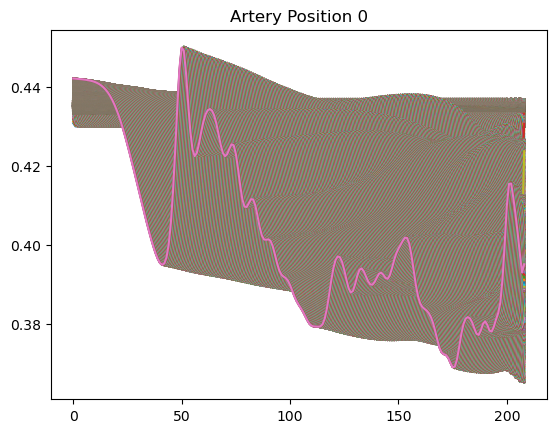

In [11]:
# run solver
an.solve(q_in, out_bc, out_args)
tt.toc() 

# redimensionalise
an.redimensionalise(rc, qc)
    


15 hrs

In [ ]:
try:
    an.dump_results('VamPy_ST','C:\\Users\\cbnor\\Documents\\Full Body Flow Model Project')   
except:
     an.dump_results('VamPy_ST','C:\\Users\\Cassidy.Northway\\GitRemoteRepo')